In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

/Users/liuriguang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load clean data from csv, rename columns, drop feature not
# in use, and check shape
df = pd.read_csv("data/rental-data-clean2.csv")
df.rename(columns={"Number of Schools": "School_number", 
                   "Average School Rating": "School_rating",
                   "Median Rental Price": "rental_price",
                   "Median Listing Price": "listing_price"},
         inplace=True)
df.drop("Type",axis=1,inplace=True)
df.shape

(1100, 13)

In [3]:
# Create feature and observation variable
X = df.iloc[:,2:12]
y = df.iloc[:,-1]

In [4]:
X.sample(5)

,Sqft,Beds,Bath,Built,School_number,School_rating,rental_price,listing_price,community_count,unit_count
228,577.0,1,1.0,2018.0,5,6.20,2650.0,684990.0,20,0
1047,968.0,2,2.0,2016.0,3,6.00,2650.0,684990.0,11,0
664,629.0,1,1.0,1991.0,5,8.40,2650.0,684990.0,14,1
247,723.0,1,1.0,2017.0,3,5.33,2650.0,684990.0,20,1
330,594.0,1,1.0,2013.0,4,6.25,2650.0,684990.0,18,0


In [5]:
y.sample(5)

449    15160.0
590     1995.0
17      1495.0
947     2995.0
15      3531.0
Name: Price, dtype: float64

In [6]:
# Check multicollinearity
df1 = pd.concat([y,X],axis=1)
df1.corr()

,Price,Sqft,Beds,Bath,Built,School_number,School_rating,rental_price,listing_price,community_count,unit_count
Price,1.000000,0.641508,0.393097,0.522943,0.185618,-0.278156,-0.038957,0.073999,0.063514,0.008684,-0.077777
Sqft,0.641508,1.000000,0.766995,0.687668,0.094765,-0.026517,-0.015506,-0.105692,-0.084364,-0.149325,0.037590
Beds,0.393097,0.766995,1.000000,0.664110,0.046069,0.085267,0.005463,-0.113769,-0.104340,-0.164659,0.078391
Bath,0.522943,0.687668,0.664110,1.000000,0.091397,-0.032316,-0.031016,-0.066578,-0.050207,-0.116311,-0.014515
Built,0.185618,0.094765,0.046069,0.091397,1.000000,-0.072097,0.133321,0.079708,0.094087,0.077892,0.025608
School_number,-0.278156,-0.026517,0.085267,-0.032316,-0.072097,1.000000,0.286416,-0.076514,-0.060868,0.066060,0.139229
School_rating,-0.038957,-0.015506,0.005463,-0.031016,0.133321,0.286416,1.000000,0.229107,0.291782,0.056596,0.060312
rental_price,0.073999,-0.105692,-0.113769,-0.066578,0.079708,-0.076514,0.229107,1.000000,0.854743,0.018186,-0.085848
listing_price,0.063514,-0.084364,-0.104340,-0.050207,0.094087,-0.060868,0.291782,0.854743,1.000000,0.018924,-0.064105
community_count,0.008684,-0.149325,-0.164659,-0.116311,0.077892,0.066060,0.056596,0.018186,0.018924,1.000000,0.054806


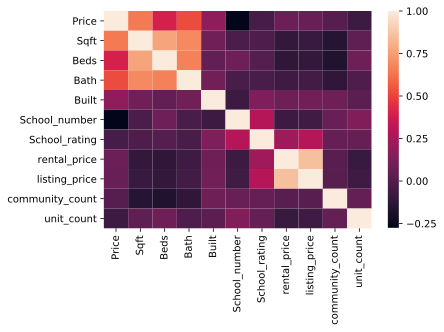

In [7]:
sns.heatmap(df1.corr())

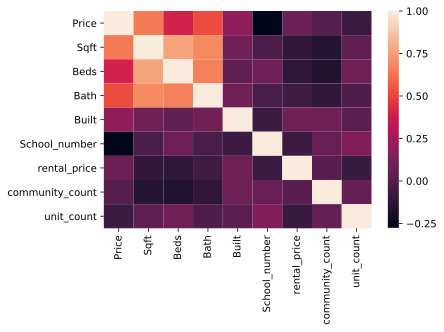

In [8]:
Xa = X.iloc[:,[0,1,2,3,4,6,8,9]]
df2 = pd.concat([y,Xa],axis=1)
sns.heatmap(df2.corr())

We see rental_price and listing_price are highly correlated. One of them needs to be taken out.

In [9]:
# Build up a ordinary least square model with statsmodel
x_part = " + ".join(X.columns)
string = y.name + ' ~ ' + x_part
y1,X1 = patsy.dmatrices(string,data=df,return_type="dataframe")
model = sm.OLS(y1,X1)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     132.5
Date:                Wed, 10 Oct 2018   Prob (F-statistic):          2.01e-180
Time:                        21:56:09   Log-Likelihood:                -9134.9
No. Observations:                1100   AIC:                         1.829e+04
Df Residuals:                    1089   BIC:                         1.835e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.389e+04   3093.447     -4.490      0.000      -2e+04   -7820.163
Sqft                2.4373      0.122     19.906      0.000       2.197       2.678
Beds             -356.2730     55.674     -6.399      0.000    -465.514    -247.032
Bath              596.9922     88.266      6.764      0.000     423.802     770.183
Built               5.8529      1.521      3.849      0.000       2.869       8.836
School_number    -345.3570     34.178    -10.105      0.000    -412.418    -278.296
School_rating       7.9883     20.666      0.387      0.699     -32.561      48.538
rental_price        1.6230      0.491      3.304      0.001       0.659       2.587
listing_price      -0.0011      0.001     -0.790      0.429      -0.004       0.002
community_count     8.0873      1.565      5.166      0.000       5.016      11.159
unit_count       -142.3902     57.050     -2.496      0.013    -254.330     -30.451
==============================================================================
Omnibus:                      808.177   Durbin-Watson:                   0.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37814.768
Skew:                           2.856   Prob(JB):                         0.00
Kurtosis:                      31.150   Cond. No.                     7.08e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.08e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see School_rating and listing_price have significantly high p-values, which indicates they have no contribution to the predict variable. A new model shall be created with these two columns taken out. Additionally, the multicollinearity issue can be addressed by dropping variable listing_price. 

In [10]:
x_part = " + ".join(Xa.columns)
string = y.name + ' ~ ' + x_part
y2,X2 = patsy.dmatrices(string,data=df,return_type="dataframe")
model2 = sm.OLS(y2,X2)
fit = model2.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     165.7
Date:                Wed, 10 Oct 2018   Prob (F-statistic):          1.70e-182
Time:                        21:56:09   Log-Likelihood:                -9135.3
No. Observations:                1100   AIC:                         1.829e+04
Df Residuals:                    1091   BIC:                         1.833e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1.388e+04   3039.351     -4.566      0.000   -1.98e+04   -7913.476
Sqft                2.4360      0.122     19.915      0.000       2.196       2.676
Beds             -354.4319     55.593     -6.375      0.000    -463.513    -245.351
Bath              594.7134     88.152      6.746      0.000     421.747     767.679
Built               5.8810      1.504      3.911      0.000       2.930       8.832
School_number    -341.6078     32.428    -10.534      0.000    -405.236    -277.980
rental_price        1.3132      0.258      5.099      0.000       0.808       1.819
community_count     8.1024      1.564      5.180      0.000       5.033      11.171
unit_count       -142.4432     56.978     -2.500      0.013    -254.241     -30.645
==============================================================================
Omnibus:                      808.019   Durbin-Watson:                   0.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38018.470
Skew:                           2.853   Prob(JB):                         0.00
Kurtosis:                      31.230   Cond. No.                     3.50e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-square does not seem to improve much. But we do not have any significantly high p-values right now. 

In [11]:
Xa.shape[1]

8

In [12]:
lr = LinearRegression()
lr.fit(Xa,y)
print(lr.score(Xa,y))

0.5485813944728735


In [13]:
degree = 2
est = make_pipeline(PolynomialFeatures(degree),
                    StandardScaler(), 
                    LinearRegression())
est.fit(Xa,y)
print(est.score(Xa,y))

0.8423126019057917


In [14]:
Xa_train, Xa_test, ya_train, ya_test = train_test_split(Xa, y, test_size=0.3)

est.fit(Xa_train, ya_train)
print(est.score(Xa_train, ya_train))
print(est.score(Xa_test, ya_test))

0.8305403207622879
0.8150894217411563


In [15]:
from sklearn.cross_validation import cross_val_score

In [16]:
scores = cross_val_score(est, Xa_train, ya_train, cv=3, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Rˆ2 for each cross-val:',scores,'\n')
print('Mean Rˆ2 of all cross vals:',np.mean(scores),'+-',np.std(scores))

Rˆ2 for each cross-val: [0.49607732 0.27227778 0.65219306] 

Mean Rˆ2 of all cross vals: 0.47351605113276635 +- 0.15591806219103782


In [17]:
scores = cross_val_score(est, Xa_train, ya_train, cv=3, scoring='neg_mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Mean for each cross-val:',-scores,'\n')
print('Mean of all cross vals:',np.mean(-scores),'+-',np.std(-scores))

Mean for each cross-val: [1112439.31074879 1041852.38116133  635232.45468158] 

Mean of all cross vals: 929841.3821972354 +- 210303.6594801085


In [18]:
import scipy.stats as stats

In [19]:
def diagnostic_plot(x, y, model):
    plt.figure(figsize=(5,10))
    
    model.fit(x,y)
    pred = model.predict(x)

    plt.subplot(3, 1, 1)
    plt.scatter(pred,y,s=1)
    plt.title("Regression fit")
    plt.xlabel("truth")
    plt.ylabel("pred")
    
    plt.subplot(3, 1, 2)
    res = y - pred
    plt.scatter(pred, res, s=1)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(3, 1, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")
    plt.tight_layout()

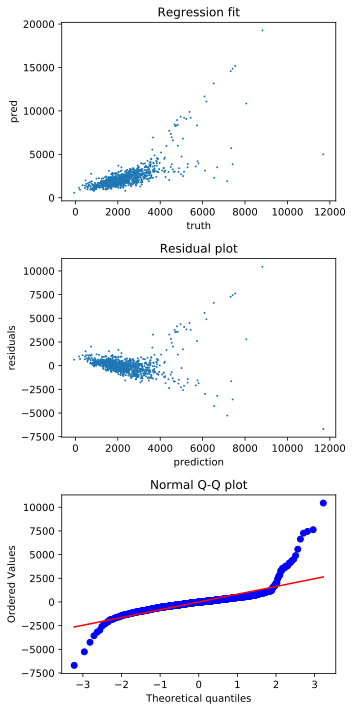

In [20]:
lr = LinearRegression()
diagnostic_plot(Xa, y, lr)

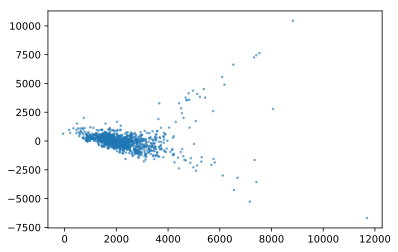

In [21]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis
model = lr.fit(Xa,y)
pred = model.predict(Xa)
resid = y - pred
plt.scatter(pred,resid,s=3,alpha=0.5)

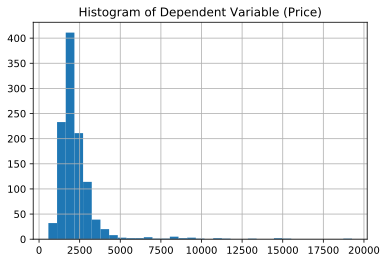

In [22]:
y.hist(bins=35)
plt.title('Histogram of Dependent Variable (Price)');

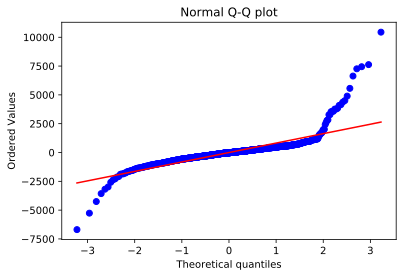

In [23]:
# We can diagnose/ inspect our residual normality assumption using qqplot:
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

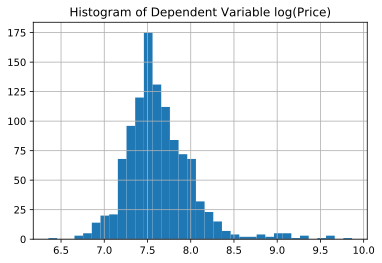

In [42]:
np.log(y).hist(bins=35)
plt.title('Histogram of Dependent Variable log(Price)');

In [25]:
log_y = np.log(y)

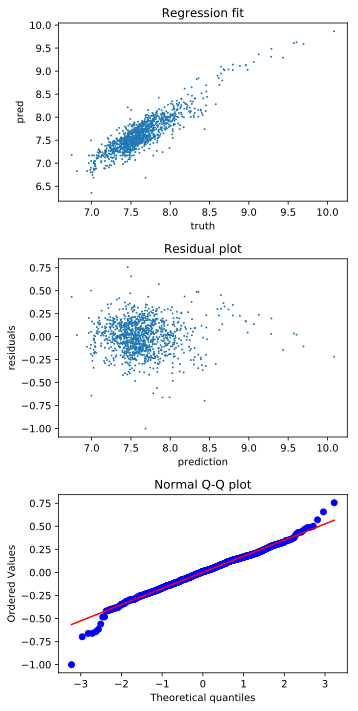

In [26]:
diagnostic_plot(Xa, log_y, est)

0.04965107986605886


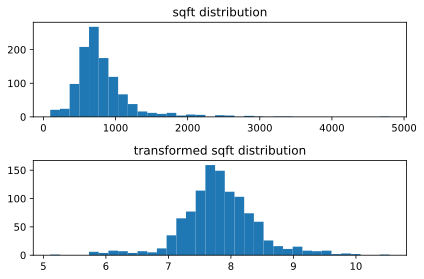

In [27]:
plt.hist(Xa.Sqft,bins=35)
sqft_lamb = stats.boxcox_normmax(Xa.Sqft)
print(sqft_lamb)
sqft_trans = stats.boxcox(Xa.Sqft, sqft_lamb)
plt.subplot(2,1,1)
plt.hist(Xa.Sqft, bins=35)
plt.title("sqft distribution")
plt.subplot(2,1,2)
plt.hist(sqft_trans, bins=35)
plt.title("transformed sqft distribution")
plt.tight_layout()

In [28]:
Xa["sqft_trans"] = sqft_trans
Xa.drop(["Sqft"],axis=1, inplace=True)

/Users/liuriguang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/liuriguang/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [29]:
degree = 2
est = make_pipeline(PolynomialFeatures(degree),
                    StandardScaler(), 
                    LinearRegression())

Text(0.5,1,'residual plot of log(y) vs tranform(X)')

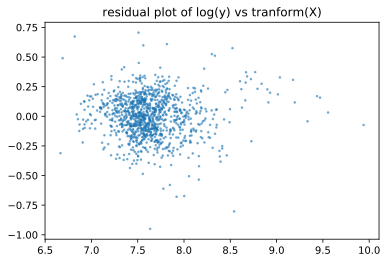

In [44]:
# Plot predicted values on the x-axis, and your residuals on the y-axis
log_model = est.fit(Xa,log_y)
pred_logy = log_model.predict(Xa)
resid = log_y - pred_logy
plt.scatter(pred_logy,resid,s=3,alpha=0.5)
plt.title("residual plot of log(y) vs tranform(X)")

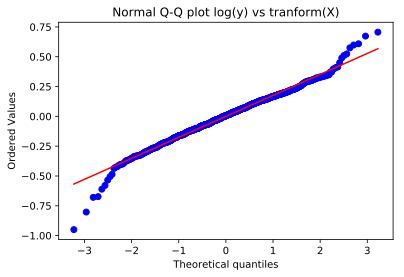

In [45]:
stats.probplot(resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot log(y) vs tranform(X)")
plt.show()

In [32]:
lr.fit(Xa,log_y)
print(lr.score(Xa,log_y))
est.fit(Xa,log_y)
print(est.score(Xa,log_y))

0.6759191448737425
0.7999205194835176


In [33]:
Xtrans_train, Xtrans_test, logy_train, logy_test = train_test_split(Xa, log_y, test_size=0.3)

est.fit(Xtrans_train, logy_train)
print(est.score(Xtrans_train, logy_train))
print(est.score(Xtrans_test, logy_test))

0.7966756446970907
0.7797708232507315


In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
print(mean_squared_error(logy_train, est.predict(Xtrans_train)))
print(mean_squared_error(logy_test, est.predict(Xtrans_test)))

0.030586564830857397
0.037183265487285726


$e^{\sqrt{0.037}}=1.212$

$e^{\sqrt{0.031}}=1.192$

So the final deviation between predicted price and real price is about 1.212/1.192 - 1 $\approx$ 1.6%

In [36]:
scores = cross_val_score(est, Xtrans_train, logy_train, cv=5, scoring='r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Rˆ2 for each cross-val:',scores,'\n')
print('Mean Rˆ2 of all cross vals:',np.mean(scores),'+-',np.std(scores))

Rˆ2 for each cross-val: [0.74489605 0.6987753  0.7569     0.68365827 0.76676371] 

Mean Rˆ2 of all cross vals: 0.730198664750245 +- 0.03292237513146913


In [37]:
scores = cross_val_score(est, Xtrans_train, logy_train, cv=5, scoring='neg_mean_squared_error')
# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print('Mean for each cross-val:',-scores,'\n')
print('Mean of all cross vals:',np.mean(-scores),'+-',np.std(-scores))

Mean for each cross-val: [0.04289415 0.05369756 0.03024746 0.04918211 0.02792028] 

Mean of all cross vals: 0.040788310777655365 +- 0.010180716706751905


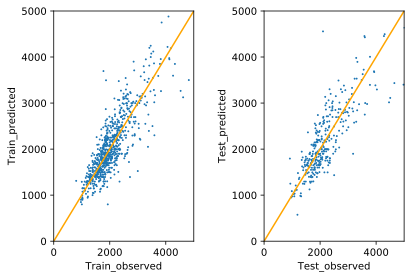

In [38]:
x_plot = np.linspace(0,5000,5000)

plt.subplot(1,2,1)
train_pred = est.predict(Xtrans_train)
plt.scatter(np.exp(train_pred), np.exp(logy_train), s=1)
plt.plot(x_plot,color = "orange")
plt.xlabel("Train_observed")
plt.ylabel("Train_predicted")
plt.xlim(0,5000)
plt.ylim(0,5000)

plt.subplot(1,2,2)
test_pred = est.predict(Xtrans_test)
plt.scatter(np.exp(test_pred), np.exp(logy_test), s=1)
plt.plot(x_plot,color = "orange")
plt.xlabel("Test_observed")
plt.ylabel("Test_predicted")
plt.xlim(0,5000)
plt.ylim(0,5000)
plt.tight_layout()